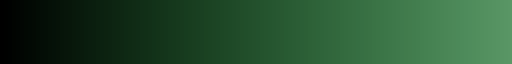

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.5, reverse=True, as_cmap=True)
# from mpl_toolkits.basemap import Basemap

In [3]:
hhct = pd.read_csv('../../data/Heat_Health_Census_Tracts.csv')
awater = gpd.read_file("../../data/external_data/tl_2020_36_tract10/tl_2020_36_tract10.shp")
urban_tree_canopy = pd.read_csv('../../clean_data/greenspace_data/urban_tree_canopy.csv')
urban_tree_canopy['GEOID'] = urban_tree_canopy['census_block'].astype(str).str[:11]
counties = ['36005', '36047', '36061', '36081', '36085']
mask = urban_tree_canopy.GEOID.str[:5].isin(counties)
urban_tree_nyc = urban_tree_canopy[mask]
cols1 = ['mean_percent_tree_cover', 'tree_gap', 'surface_temp', 'income_percent']
cols2 = ['income_group', 'pop_dens_group']
urban_tree_nyc = urban_tree_nyc[cols1 + cols2 + ['GEOID']]
dct = {}
for col in cols1:
    dct[col] = 'mean'
for col in cols2:
    dct[col] = 'mean'
urban_tree_nyc = urban_tree_nyc.groupby('GEOID').agg({**dct}).reset_index()
urban_tree_nyc['GEOID'] = urban_tree_nyc['GEOID'].map(int)


In [4]:
hhct['county_fip'] = hhct['GEOID'].map(lambda x: str(x)[:5])
mask = hhct.county_fip.isin(counties)
hhct = hhct[mask]
mask = awater.GEOID10.str[:5].isin(counties)
awater = awater[mask]

In [5]:
# take important columns
awater_df = awater[['GEOID10', 'ALAND10', 'AWATER10', 'geometry']]
awater_df['GEOID10'] = awater_df['GEOID10'].map(int)
hhct_df = hhct[['GEOID', 'High_Summer_Mean_LST_F', 'Summer_Mean_LST_F', 'MEAN_PCT_ImperviousSurfaces']]
awater_df = pd.merge(hhct_df, awater_df, left_on='GEOID', right_on='GEOID10', how='left')
del awater_df['GEOID10']

dc_GEOID_surfact_temp = dict(zip(urban_tree_nyc.GEOID, urban_tree_nyc.surface_temp))
awater_df['surface_temp'] = awater_df.GEOID.map(dc_GEOID_surfact_temp) 
mt = awater_df['surface_temp'].mean()
awater_df['surface_temp'].fillna(mt, inplace=True)


dc_GEOID_mean_cover = dict(zip(urban_tree_nyc.GEOID, urban_tree_nyc.mean_percent_tree_cover))
awater_df['mean_percent_tree_cover'] = awater_df.GEOID.map(dc_GEOID_mean_cover) 
mt = awater_df['mean_percent_tree_cover'].mean()
awater_df['mean_percent_tree_cover'].fillna(mt, inplace=True)



awater_df['High_Summer_Mean_LST_C'] = awater_df.High_Summer_Mean_LST_F.map(lambda x: (x-32)*5/9)
awater_df['Summer_Mean_LST_C'] = awater_df.Summer_Mean_LST_F.map(lambda x: (x-32)*5/9)

awater_df['diff1'] = awater_df['High_Summer_Mean_LST_C'] - awater_df['surface_temp']
awater_df['diff2'] = awater_df['Summer_Mean_LST_C'] - awater_df['surface_temp']


/Users/arnhavdatar/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
awater_df[['High_Summer_Mean_LST_F', 'Summer_Mean_LST_F']]

,High_Summer_Mean_LST_F,Summer_Mean_LST_F
0,83.243164,83.243164
1,96.719470,96.719470
2,96.964211,96.964211
3,98.472110,98.472110
4,95.803680,95.803680
...,...,...
2159,97.516850,97.516850
2160,97.516846,97.516846
2161,93.269470,93.269470
2162,88.027367,88.027367


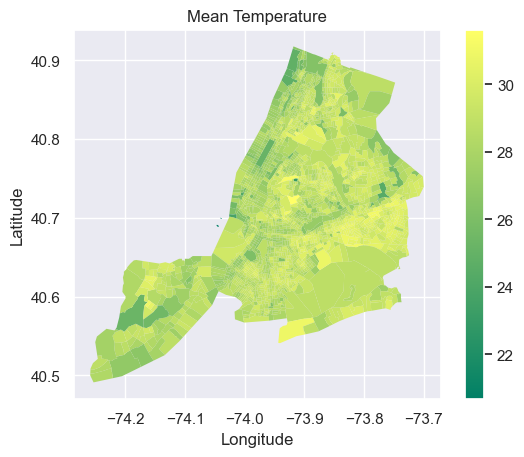

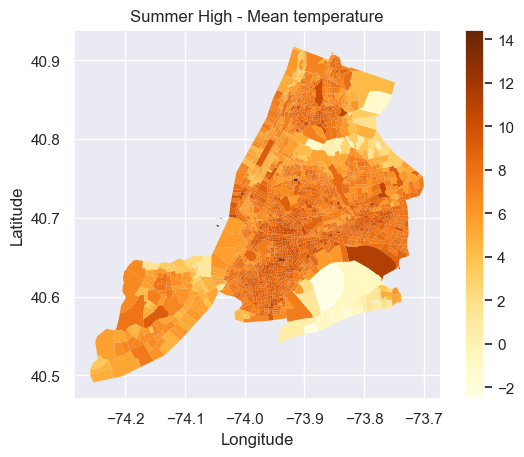

In [7]:

awater_df = gpd.GeoDataFrame(awater_df, geometry='geometry')
awater_df.plot(column='surface_temp', cmap='summer', legend=True, edgecolor = 'none')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Mean Temperature")
plt.savefig('./temp_plots/temp.png')

awater_df.plot(column='diff1', cmap='YlOrBr', legend=True, edgecolor = 'none')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Summer High - Mean temperature")
plt.savefig('./temp_plots/temp_diff.png')

plt.show()

<AxesSubplot:>

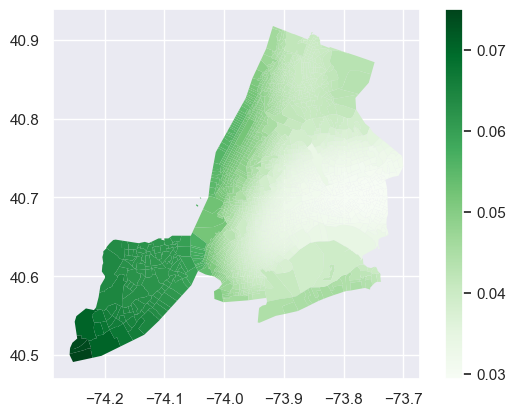

In [8]:
merged = awater_df
# calculate percentage of water
awater_df['water_percentage'] = awater_df['AWATER10']/(awater_df['ALAND10'] + awater_df['AWATER10'])
awater_df['latitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.x,
    axis=1
)
awater_df['longitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.y,
    axis=1
)

def app(row):
    lat_diff = (merged['latitude'] - row.latitude) * 0.652
    long_diff = (merged['longitude'] - row.longitude) * 0.546
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(-np.sqrt(distance) * 10)
    weighted_exp_dist = exp_dist * merged['mean_percent_tree_cover'] 
    return weighted_exp_dist.sum() / exp_dist.sum()

merged['green_gaussian'] = merged.apply(
    lambda row: app(row),
    axis=1
)


def app(row):
    lat_diff = (merged['latitude'] - row.latitude) 
    long_diff = (merged['longitude'] - row.longitude)
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(- np.sqrt(distance) * 10 ) 
    weighted_exp_dist = exp_dist * merged['water_percentage'] 
    return weighted_exp_dist.sum() / exp_dist.sum()

merged['water_gaussian'] = merged.apply(
    lambda row: app(row),
    axis=1
)

awater_df.plot(column='water_gaussian', cmap='Greens', legend=True, edgecolor = 'none')


In [9]:
nyc_census_data = pd.read_csv('nyc_census_tracts.csv')
nyc_census_data

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,36085030302,Richmond,Staten Island,6279,3093,3186,35.8,28.7,17.6,0.0,...,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
2163,36085031901,Richmond,Staten Island,2550,953,1597,27.1,6.2,60.4,0.0,...,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
2164,36085031902,Richmond,Staten Island,4611,2043,2568,20.9,14.7,61.9,0.0,...,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4
2165,36085032300,Richmond,Staten Island,1131,597,534,45.5,24.0,29.7,0.0,...,4.9,0.0,0.0,52.5,534,65.0,31.1,3.9,0.0,10.7


In [10]:
df = pd.merge(awater_df, nyc_census_data, left_on='GEOID', right_on='CensusTract', how='right')
print(df.columns)

Index(['GEOID', 'High_Summer_Mean_LST_F', 'Summer_Mean_LST_F',
       'MEAN_PCT_ImperviousSurfaces', 'ALAND10', 'AWATER10', 'geometry',
       'surface_temp', 'mean_percent_tree_cover', 'High_Summer_Mean_LST_C',
       'Summer_Mean_LST_C', 'diff1', 'diff2', 'water_percentage', 'latitude',
       'longitude', 'green_gaussian', 'water_gaussian', 'CensusTract',
       'County', 'Borough', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White',
       'Black', 'Native', 'Asian', 'Citizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')


In [11]:
imdf = df[['GEOID', 'mean_percent_tree_cover', 'water_percentage', 'water_gaussian', 'green_gaussian', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White',
       'Black', 'Native', 'Asian', 'Citizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'ALAND10']]
imdf['Population_Density'] = imdf['TotalPop'] / imdf['ALAND10']
imdf['Gender_Ratio'] = imdf['Men'] / imdf['Men'] + imdf['Women']

/var/folders/pl/tr7722ys2bdgctv1qd3njn380000gn/T/ipykernel_55802/1712608024.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdf['Population_Density'] = imdf['TotalPop'] / imdf['ALAND10']
/var/folders/pl/tr7722ys2bdgctv1qd3njn380000gn/T/ipykernel_55802/1712608024.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdf['Gender_Ratio'] = imdf['Men'] / imdf['Men'] + imdf['Women']


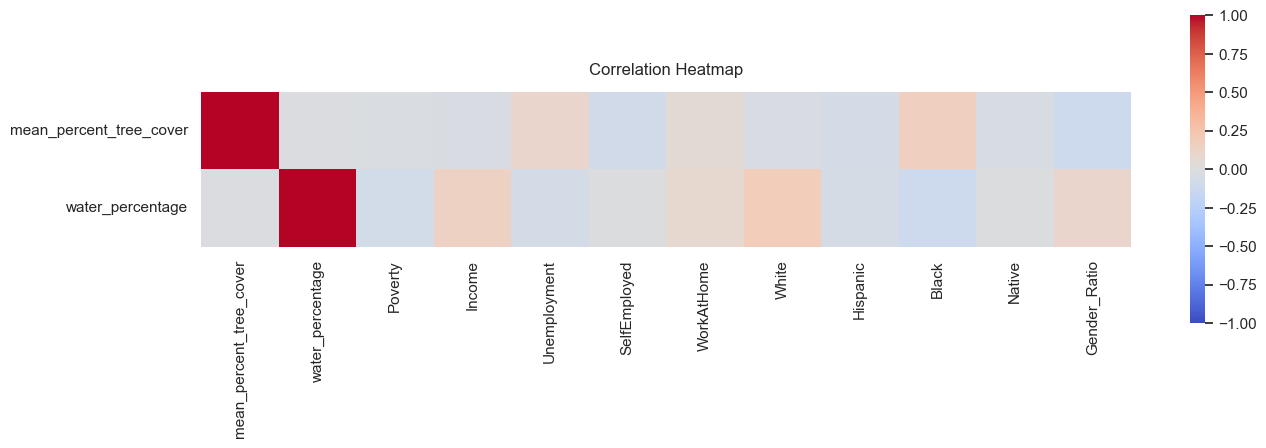

In [23]:
# pl = sns.color_palette("vlag", as_cmap=True)
fig, ax = plt.subplots(figsize=(15,5))
corr = imdf.corr()[['mean_percent_tree_cover', 'water_percentage', 'Poverty', 'Income', 'Unemployment', 'SelfEmployed', 'WorkAtHome', 'White', 'Hispanic', 'Black' , 'Native', 'Gender_Ratio']][1:3]
pl = sns.color_palette("coolwarm", as_cmap=True)
hm = sns.heatmap(corr, cmap = 'coolwarm' ,square = True, center = 0, vmin = -1, vmax = 1,  cbar_kws={"shrink": 0.8})
hm.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('correlation_new.png', bbox_inches = 'tight')

In [61]:
imdf.corr()[[ 'Unemployment', 'IncomePerCap', 'Professional',  'TotalPop',  'Black', 'Poverty' ]][1:5]

,Unemployment,IncomePerCap,Professional,TotalPop,Black,Poverty
mean_percent_tree_cover,0.096208,-0.156904,-0.030850,-0.180053,0.163558,-0.028844
water_percentage,-0.077894,0.166804,0.192532,0.067882,-0.110968,-0.078283
water_gaussian,-0.136941,0.357286,0.351706,0.229720,-0.329226,0.007802
green_gaussian,0.029332,-0.335890,-0.320037,-0.191690,0.239094,-0.232403


In [62]:

for i in (imdf.columns):
    print(i, corr[i][0], corr[i][1])

GEOID 0.06666962233615767 0.04167760872872785
mean_percent_tree_cover 1.0 -0.01902789670873967
water_percentage -0.01902789670873967 1.0
water_gaussian -0.10770432693171186 0.3050556477400594
green_gaussian 0.326962042230498 -0.10832389815367613
TotalPop -0.1800525888742444 0.06788162371930792
Men -0.2060478592567658 0.07080600333277323
Women -0.1517903831391368 0.06325777479580005
Hispanic -0.06538727018992255 -0.05719588723935813
White -0.03201436730586565 0.18434234404491714
Black 0.16355768403482848 -0.11096758284013085
Native -0.046665680265069884 -0.011291540822105811
Asian -0.13245253288372127 -0.052675521057474084
Citizen -0.1268466580787737 0.12730207218340212
Income -0.036336052888176554 0.14822730510106058
IncomeErr -0.06594532675968807 0.10354070929667304
IncomePerCap -0.15690427281975455 0.16680356270242325
IncomePerCapErr -0.11030069975058478 0.14456617887789752
Poverty -0.02884416428753911 -0.07828252025456185
ChildPoverty -0.04986971055879401 -0.11454614662063965
Profes

In [76]:
import statsmodels.regression.linear_model as sm
formula = 'mean_percent_tree_cover ~ Poverty '
reg = sm.OLS.from_formula(formula, data=imdf).fit()
print(reg.summary())

                               OLS Regression Results                              
Dep. Variable:     mean_percent_tree_cover   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     1.768
Date:                     Sun, 12 Feb 2023   Prob (F-statistic):              0.184
Time:                             00:32:37   Log-Likelihood:                 1919.7
No. Observations:                     2125   AIC:                            -3835.
Df Residuals:                         2123   BIC:                            -3824.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In